In [1]:
import os
original_path = os.getcwd()
root = '/rhome/yhu/bigdata/proj/experiment_GIST'
os.chdir(root)
new_path = os.getcwd()
print('redirect path: \n\t{} \n-->\t{}'.format(original_path, new_path))
print('root: {}'.format(root))

import warnings
warnings.filterwarnings('ignore')

from GIST.prepare.utils import load_hic, load_hic, iced_normalization
from GIST.visualize import display, load_data
from GIST.validation.utils import load_df_fish3d, fish3d_format, load_tad_bed
from GIST.validation.utils import pdist_3d, load_tad_bed, select_loci, remove_failed
from GIST.validation.validation_tad import select_structure3d
from GIST.validation.ab import normalizebydistance, decomposition, correlation, plot
from GIST.validation.ab import fit_genomic_spatial_func

import numpy as np
import torch
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.spatial.distance import cdist, pdist, squareform
import plotly.express as px
import matplotlib
from scipy import stats

redirect path: 
	/bigdata/wmalab/yhu/proj/notes/exp_GIST 
-->	/bigdata/wmalab/yhu/proj/experiment_GIST
root: /rhome/yhu/bigdata/proj/experiment_GIST


Using backend: pytorch


In [2]:
chroms = ['20', '21', '22']
validation_name = 'relative_error'
SAVE_FIG = False
font = {'size': 18}
matplotlib.rc('font', **font)

In [3]:
methods = ['ShRec3D', 'LorDG', 'pastis', 'GEM', 'ChromSDE'] # 'ShRec3D', 'LorDG', 
results_name = dict()
results_name['ShRec3D'] = 'conformation.xyz'
results_name['pastis'] = 'PM2.structure'
results_name['GEM'] = 'conformation_'
results_name['LorDG'] = 'output/conformation.xyz'
results_name['ChromSDE'] = 'conformation.xyz'

In [4]:
structures = dict()
xweights = dict()
raw2rm = dict()
rm2raw = dict()
raw_id = dict()

for chrom in chroms:
    # load config .json
    configuration_path = os.path.join(root, 'data')
    configuration_name = 'config_predict_{}.json'.format(chrom)
    info, config_data = load_data.load_configuration(configuration_path, configuration_name)
    resolution = info['resolution']
    # info['hyper'] =  '10kb_predict_{}'.format(chrom)

    saved_path = os.path.join(root, 'figures', validation_name, info['cell'], )
    os.makedirs(saved_path, exist_ok=True)
    print('figure saved in {}'.format(saved_path))

    # load dataset
    dataset_path = os.path.join(root, 'data', info['cell'], info['hyper'])
    dataset_name = 'dataset.pt'
    print('load data: {}, {}'.format(dataset_path, dataset_name))
    HD = load_data.load_dataset(dataset_path, dataset_name)
    graph, feat, ratio, indx  = HD[0]
    raw_id[chrom] = graph['top_graph'].ndata['id'].cpu().numpy()
    rmNaN_id = np.arange(len(raw_id[chrom]))
    raw2rm[chrom] = {} # raw -> rm id
    rm2raw[chrom] = {} # rm -> raw id
    for A, B in zip(raw_id[chrom], rmNaN_id):
        raw2rm[chrom][A] = B
        rm2raw[chrom][B] = A

    # load prediction
    prediction_path = os.path.join(root, 'data', info['cell'], info['hyper'], 'output')
    prediction_name = 'prediction.pkl'
    prediction = load_data.load_prediction(prediction_path, prediction_name)

    # assignment
    structures[chrom] = dict()
    structures[chrom]['GIST'] = prediction['{}_0'.format(chrom)]['structures']
    xweights[chrom] = prediction['{}_0'.format(chrom)]['structures_weights'].astype(float).flatten()
#     true_cluster = np.array(prediction['{}_0'.format(chrom)]['true_cluster'])
#     predict_cluster = np.array(prediction['{}_0'.format(chrom)]['predict_cluster'][0])
    print( 'GIST structure shape: ', structures[chrom]['GIST'].shape )

figure saved in /rhome/yhu/bigdata/proj/experiment_GIST/figures/relative_error/Rao2014-IMR90-MboI-allreps-filtered
load data: /rhome/yhu/bigdata/proj/experiment_GIST/data/Rao2014-IMR90-MboI-allreps-filtered/10kb_predict_v2_20, dataset.pt
GIST structure shape:  (5772, 40, 3)
figure saved in /rhome/yhu/bigdata/proj/experiment_GIST/figures/relative_error/Rao2014-IMR90-MboI-allreps-filtered
load data: /rhome/yhu/bigdata/proj/experiment_GIST/data/Rao2014-IMR90-MboI-allreps-filtered/10kb_predict_v2_21, dataset.pt
GIST structure shape:  (3222, 40, 3)
figure saved in /rhome/yhu/bigdata/proj/experiment_GIST/figures/relative_error/Rao2014-IMR90-MboI-allreps-filtered
load data: /rhome/yhu/bigdata/proj/experiment_GIST/data/Rao2014-IMR90-MboI-allreps-filtered/10kb_predict_v2_22, dataset.pt
GIST structure shape:  (3161, 40, 3)


In [5]:
for chrom in chroms:
    for i, m in enumerate(methods):
        re = info['cool_file'].split('.')[1]
        mpath = os.path.join(root, 'comparison', m.lower(), info['cell'], re, chrom)
        if m.lower() != 'gem':
            file = os.path.join(mpath, results_name[m])
            if m.lower() != 'lordg':
                x = np.loadtxt(file, dtype=np.float).reshape(-1,1,3)
            elif m.lower() =='lordg':
                s = np.loadtxt(file, dtype=np.float).reshape(-1,1,4)
                x = s[:,:,0:3]
        else:
            x = list()
            for k in np.arange(1,5):
                file = os.path.join(mpath, results_name[m]+'{}.txt'.format(k))
                x.append(np.loadtxt(file, dtype=np.float).reshape(-1,1,3))
            x = np.concatenate(x, axis=1)
        structures[chrom][m] = x

    for key, value in structures[chrom].items():
        print('{} {} structure shape: {}'.format(chrom, key, value.shape) )

20 GIST structure shape: (5772, 40, 3)
20 ShRec3D structure shape: (5772, 1, 3)
20 LorDG structure shape: (5772, 1, 3)
20 pastis structure shape: (5772, 1, 3)
20 GEM structure shape: (5772, 4, 3)
20 ChromSDE structure shape: (5772, 1, 3)
21 GIST structure shape: (3222, 40, 3)
21 ShRec3D structure shape: (3222, 1, 3)
21 LorDG structure shape: (3222, 1, 3)
21 pastis structure shape: (3222, 1, 3)
21 GEM structure shape: (3222, 4, 3)
21 ChromSDE structure shape: (3222, 1, 3)
22 GIST structure shape: (3161, 40, 3)
22 ShRec3D structure shape: (3161, 1, 3)
22 LorDG structure shape: (3161, 1, 3)
22 pastis structure shape: (3161, 1, 3)
22 GEM structure shape: (3161, 4, 3)
22 ChromSDE structure shape: (3161, 1, 3)


In [6]:
path = os.path.join(root, 'data', 'FISH', 'geometry_coo')
fail_dict = {'22': 26, '21':0, '20': 11}
fish3d_pdist = dict()
for chrom in chroms:
    name = 'FISH_Chr{}.xyz'.format(chrom)
    fish3d_df = load_df_fish3d(path, name)
    data = fish3d_format(fish3d_df)
    print('xyz shape: ', data.shape)
    fish3d_pdist[chrom] = pdist_3d(data)
    print('pdist shape: ', np.nanmean(fish3d_pdist[chrom], axis=0).shape)
    # remove failed rows
    fish3d_pdist[chrom] = remove_failed(fish3d_pdist[chrom], np.array(fail_dict['{}'.format(chrom)]) )
    print('pdist shape: ', fish3d_pdist[chrom].shape)

loading fish3d excel file FISH_Chr20.xyz
xyz shape:  (111, 30, 3)
pdist shape:  (30, 30)
pdist shape:  (111, 29, 29)
loading fish3d excel file FISH_Chr21.xyz
xyz shape:  (120, 34, 3)
pdist shape:  (34, 34)
pdist shape:  (120, 33, 33)
loading fish3d excel file FISH_Chr22.xyz
xyz shape:  (151, 27, 3)
pdist shape:  (27, 27)
pdist shape:  (151, 26, 26)


In [7]:
path = os.path.join(root, 'data', 'FISH', 'loci_position')
select_idx = dict()
for chrom in chroms:
    name = 'hg19_Chr{}.bed'.format(chrom)
    df = load_tad_bed(path, name)
    select_idx[chrom] = select_loci(df, resolution)
    for i, idx in enumerate(select_idx[chrom]):
        arr = np.intersect1d(raw_id[chrom], idx)
        select_idx[chrom][i] = np.array([ raw2rm[chrom][x] for x in arr ] )

In [8]:
xTAD_pdist = dict()
for chrom in chroms:
    xTAD_pdist[chrom] = dict()
    for key, data3d in structures[chrom].items():
        index = select_idx[chrom]
        N = data3d.shape[0]
        K = data3d.shape[1]
        M = len(index)
        res = np.empty((M, K, 3))
        for i, idx in enumerate(index):
            res[i, :, :] = np.nanmean( data3d[idx.astype(int), :, :], axis=0, keepdims=True)
        print(key, 'res shape: ', res.shape, end=', ')
        xTAD_3d = res.transpose( (1, 0, 2) )
        print('after transpose shape: ', xTAD_3d.shape)
        tmp = pdist_3d(xTAD_3d)
        if key != 'GIST':
            xTAD_pdist[chrom][key] = tmp
        elif key == 'GIST':
            all_gist = np.zeros_like(tmp)
            for k in np.arange(K):
                all_gist[k,:,:] = xweights[chrom][k]*tmp[k:k+1,:,:]*len(xweights[chrom])
#                 xTAD_pdist[chrom][key+'_{}'.format(k)] = xweights[chrom][k]*tmp[k:k+1,:,:]*len(xweights[chrom])
#                 xTAD_pdist[chrom][key][k,:,:] = xweights[chrom][k]*xTAD_pdist[chrom][key][k,:,:]*len(xweights[chrom])
#                 print('pdist shape: ', np.nanmean(xTAD_pdist[chrom][key+'_{}'.format(k)], axis=0).shape)
            xTAD_pdist[chrom]['GISTavg'] = np.nanmean(all_gist, axis=0, keepdims=True)

GIST res shape:  (29, 40, 3), after transpose shape:  (40, 29, 3)
ShRec3D res shape:  (29, 1, 3), after transpose shape:  (1, 29, 3)
LorDG res shape:  (29, 1, 3), after transpose shape:  (1, 29, 3)
pastis res shape:  (29, 1, 3), after transpose shape:  (1, 29, 3)
GEM res shape:  (29, 4, 3), after transpose shape:  (4, 29, 3)
ChromSDE res shape:  (29, 1, 3), after transpose shape:  (1, 29, 3)
GIST res shape:  (33, 40, 3), after transpose shape:  (40, 33, 3)
ShRec3D res shape:  (33, 1, 3), after transpose shape:  (1, 33, 3)
LorDG res shape:  (33, 1, 3), after transpose shape:  (1, 33, 3)
pastis res shape:  (33, 1, 3), after transpose shape:  (1, 33, 3)
GEM res shape:  (33, 4, 3), after transpose shape:  (4, 33, 3)
ChromSDE res shape:  (33, 1, 3), after transpose shape:  (1, 33, 3)
GIST res shape:  (26, 40, 3), after transpose shape:  (40, 26, 3)
ShRec3D res shape:  (26, 1, 3), after transpose shape:  (1, 26, 3)
LorDG res shape:  (26, 1, 3), after transpose shape:  (1, 26, 3)
pastis res s

In [9]:
def fit_func(x, a, b):
    return a * x + b

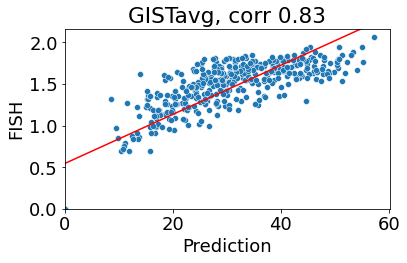

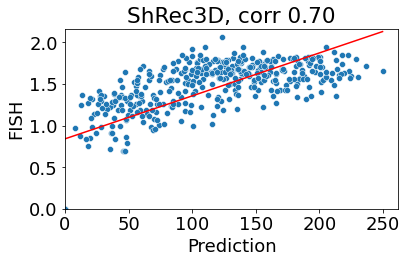

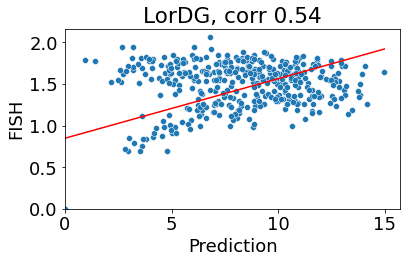

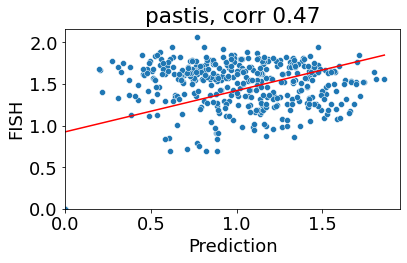

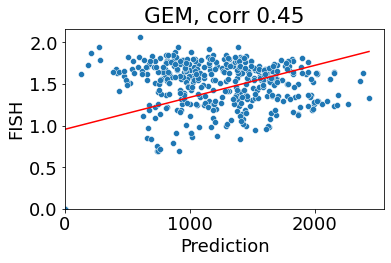

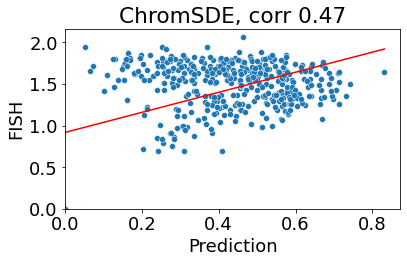

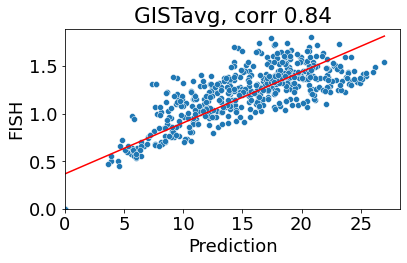

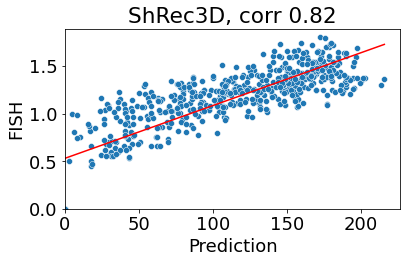

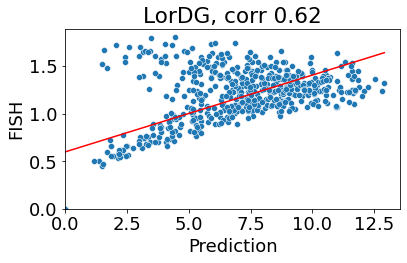

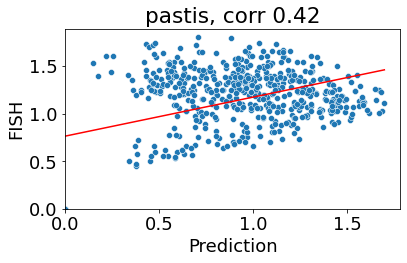

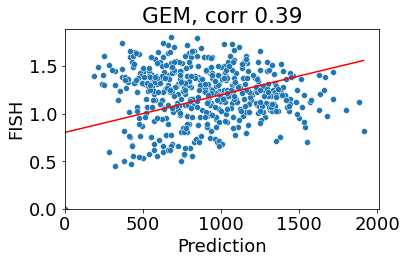

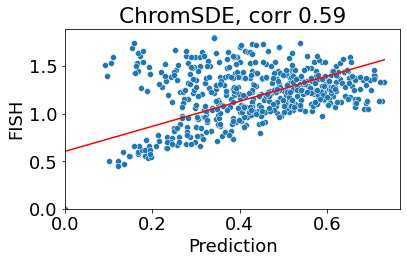

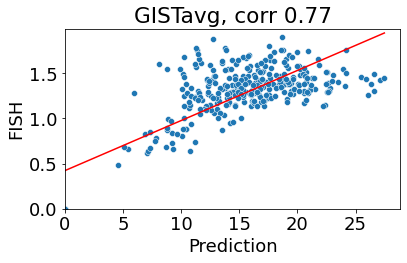

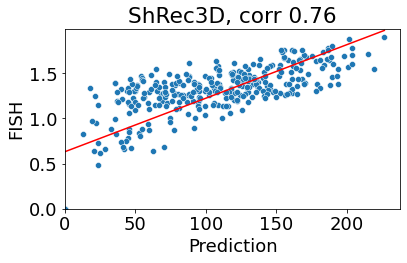

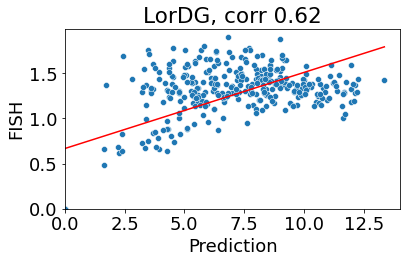

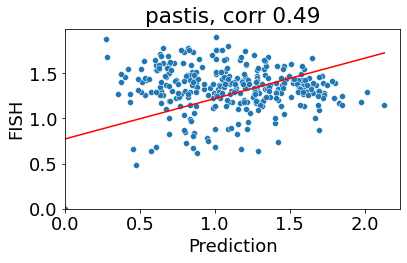

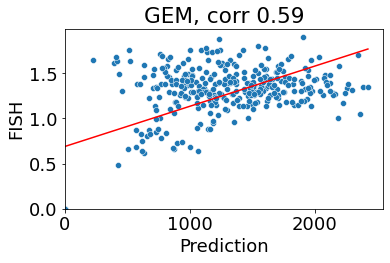

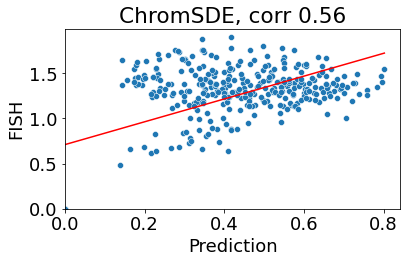

In [10]:
for chrom in chroms:
    avg_fishTAD_3d = np.nanmean(fish3d_pdist[chrom], axis=0)
    for key, pdist in xTAD_pdist[chrom].items():
        fig, axs = plt.subplots(1, 1, figsize=(6,4) ) #, gridspec_kw={'height_ratios': [1, 1]})
        avg_xTAD_3d = np.nanmean(pdist, axis=0)

        msku = np.zeros_like(avg_fishTAD_3d)
        msku[np.triu_indices_from(msku,k=0)] = True
        ff3d = avg_fishTAD_3d[msku.astype(bool)].flatten()
        fx3d = avg_xTAD_3d[msku.astype(bool)].flatten()

        params = curve_fit(fit_func, fx3d, ff3d)
        [scale, offset] = params[0]
#         print(scale, offset)

        data = {'FISH':ff3d, 'Prediction':fx3d, 'fit':fit_func(fx3d, scale, offset)}
        df = pd.DataFrame(data)

        corr = np.corrcoef(ff3d, fx3d)
        axs.set_title('{}, corr {:.2f}'.format(key, corr[0,1])) # , fontsize=28
        g = sns.scatterplot(data=df, x="Prediction", y="FISH", ax=axs)
        g.set(ylim=(0, None))
        g.set(xlim=(0, None))
        sns.lineplot(data=df, x="Prediction", y="fit", color="red", ax=axs)
        fig.tight_layout()

        # save the figure
        if SAVE_FIG:
            sp = os.path.join(saved_path,  'chr{}'.format(chrom))
            os.makedirs(sp, exist_ok=True)
            sp = os.path.join(sp, 'curvefit_chr{}_{}.pdf'.format(chrom, key))
            fig.savefig(sp, format='pdf', bbox_inches='tight')
fig.show()

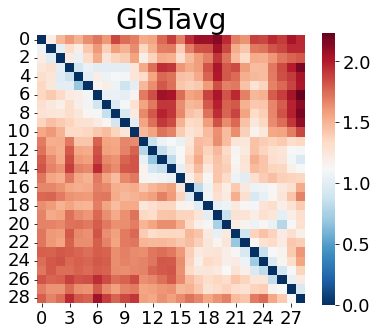

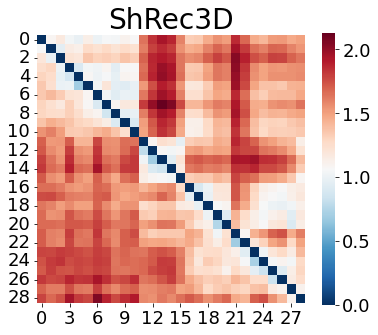

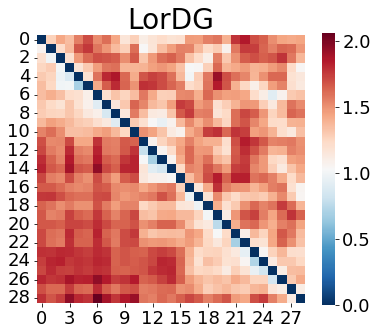

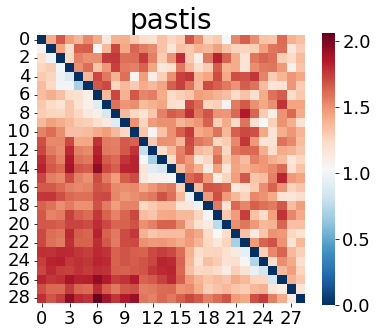

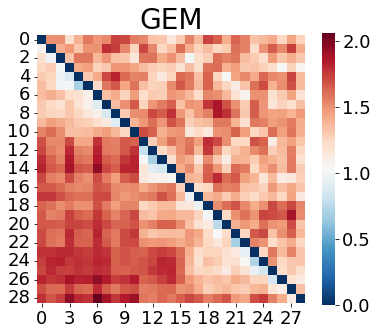

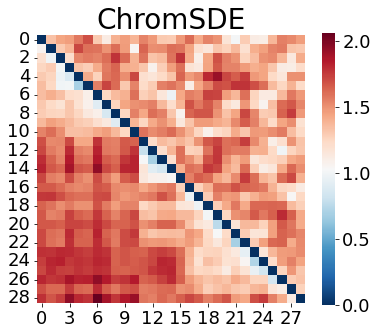

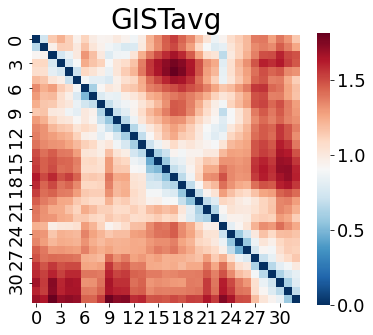

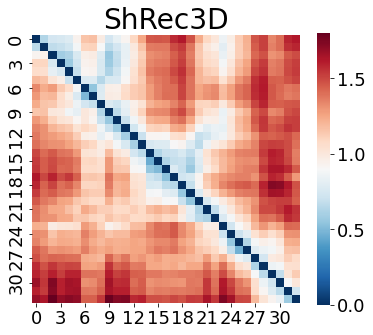

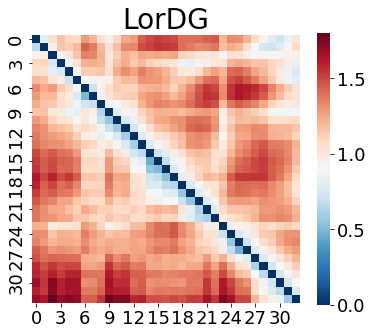

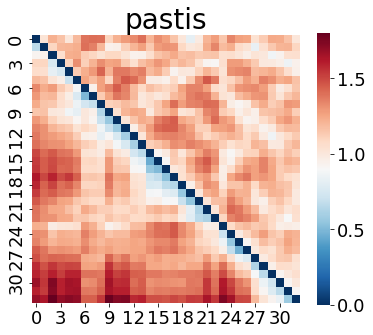

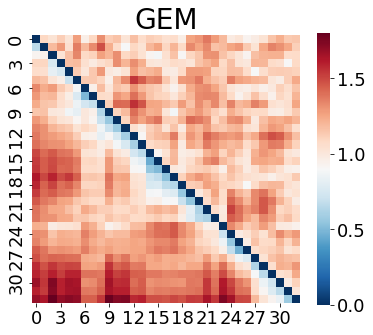

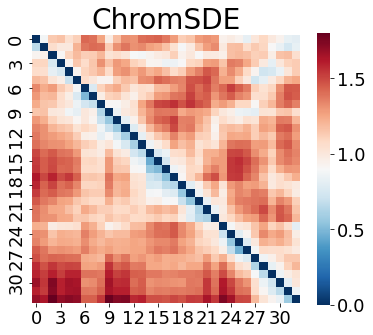

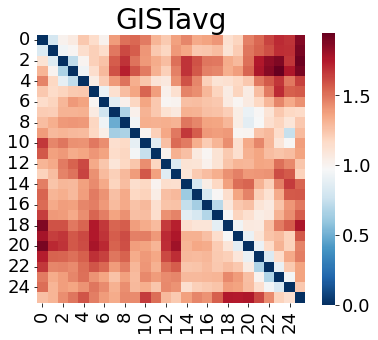

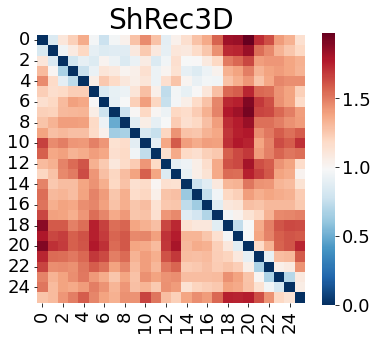

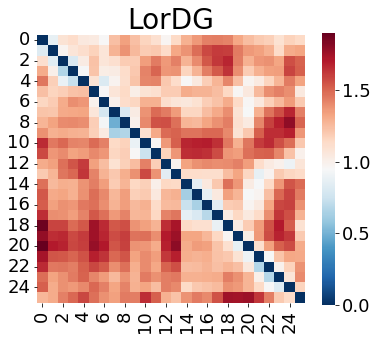

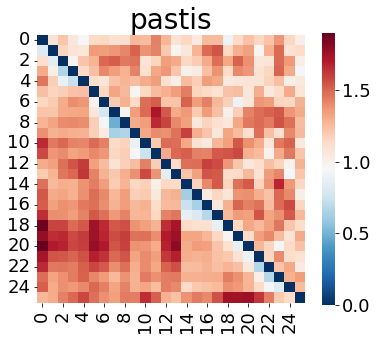

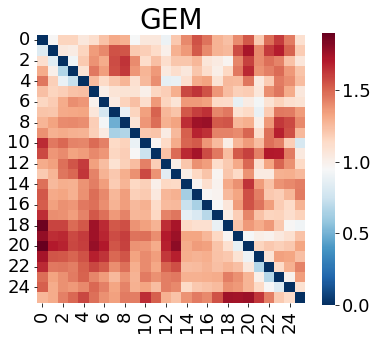

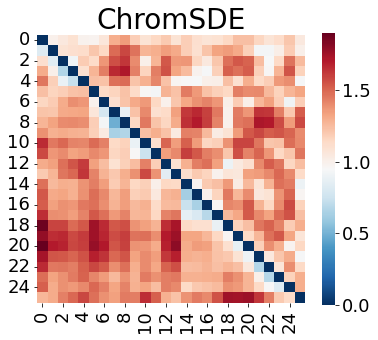

In [11]:
for chrom in chroms:
    avg_fishTAD_3d = np.nanmean(fish3d_pdist[chrom], axis=0)
    for key, pdist in xTAD_pdist[chrom].items():
        fig, axs = plt.subplots(1, 1,figsize=(6, 5))
        avg_xTAD_3d = np.nanmean(pdist, axis=0)
        msku = np.zeros_like(avg_fishTAD_3d)
        msku[np.triu_indices_from(msku,k=0)] = True
        ff3d = avg_fishTAD_3d[msku.astype(bool)].flatten()
        fx3d = avg_xTAD_3d[msku.astype(bool)].flatten()

        params = curve_fit(fit_func, fx3d, ff3d)
        [scale, offset] = params[0]
        mat = np.zeros_like(avg_fishTAD_3d)
        mat = np.tril(avg_fishTAD_3d, k=-1) + np.triu(scale*(avg_xTAD_3d)+offset, k=1)
        axs.set_title(key, fontsize=28)
        sns.heatmap(mat, vmin=0.0, cmap='RdBu_r', square=True, ax=axs)
        # save the figure
        if SAVE_FIG:
            sp = os.path.join(saved_path,  'chr{}'.format(chrom))
            os.makedirs(sp, exist_ok=True)
            sp = os.path.join(sp, 'relative_error_pdist_chr{}_{}.png'.format(chrom, key))
            fig.savefig(sp, format='png', bbox_inches='tight')

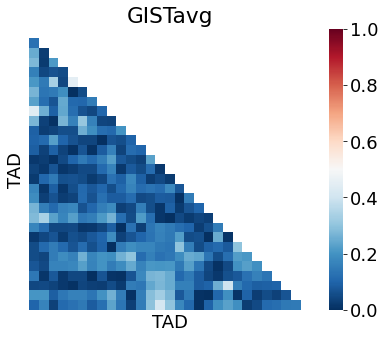

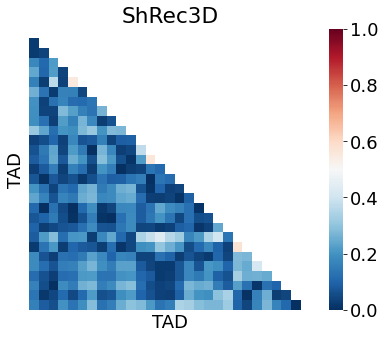

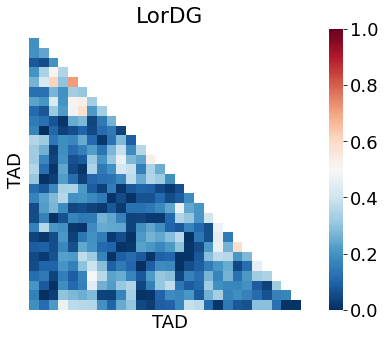

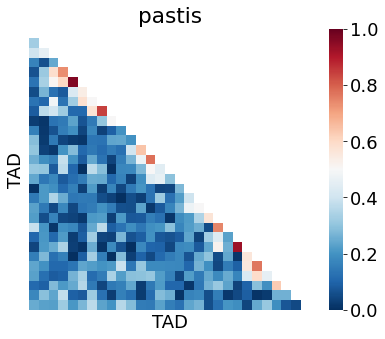

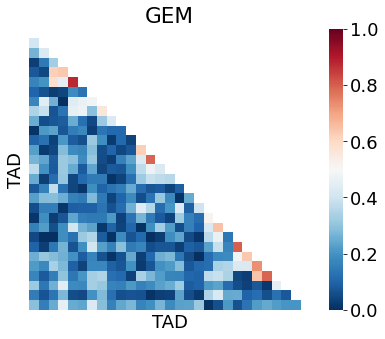

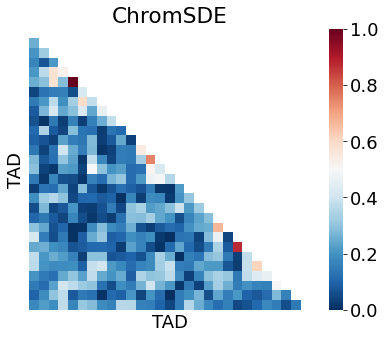

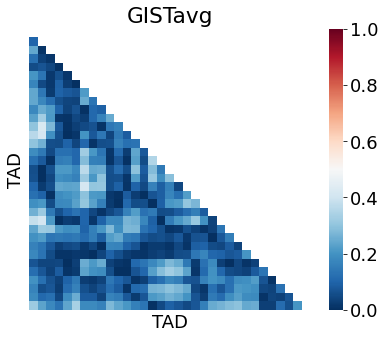

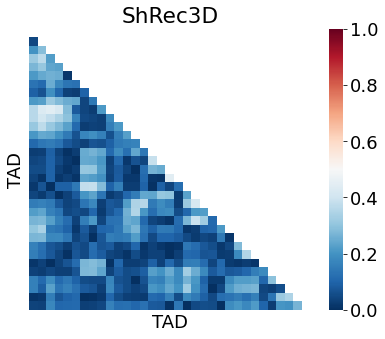

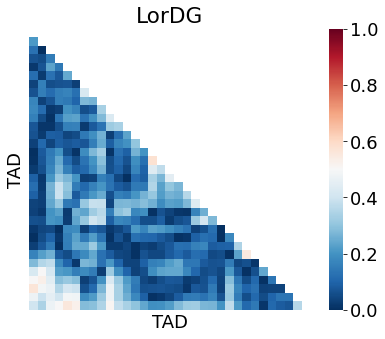

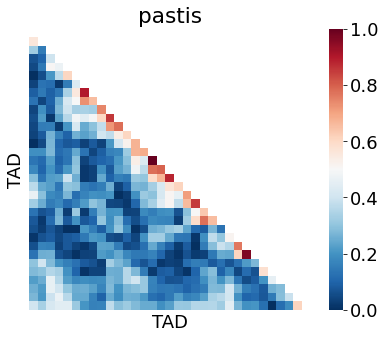

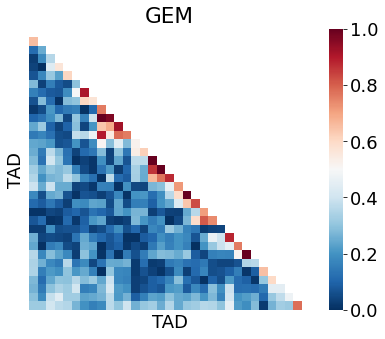

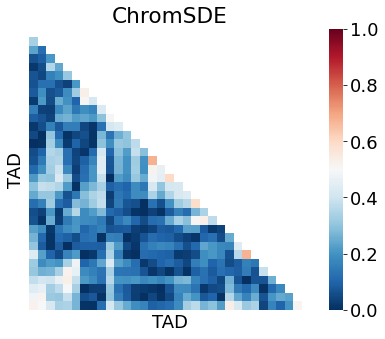

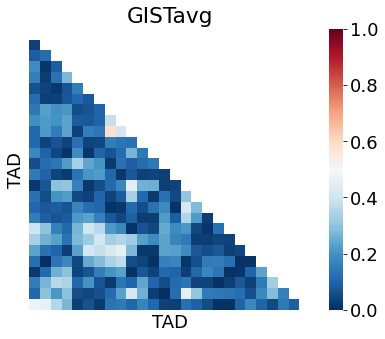

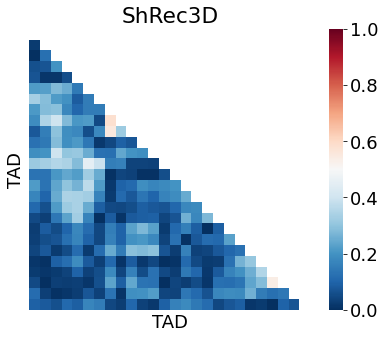

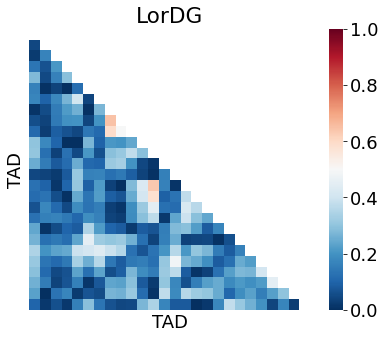

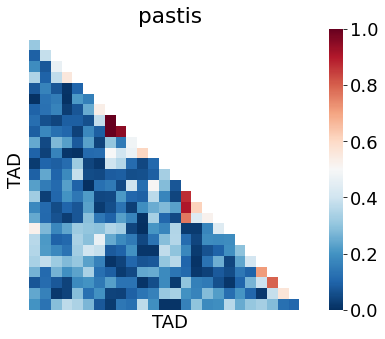

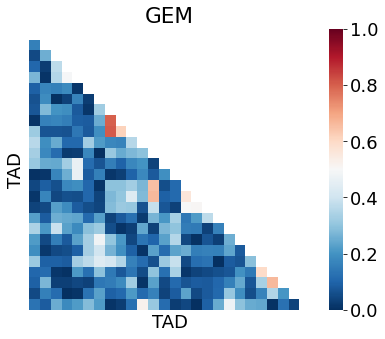

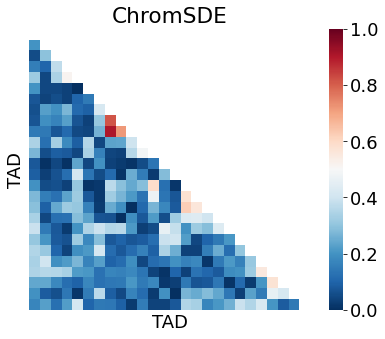

In [12]:
for chrom in chroms:
    avg_fishTAD_3d = np.nanmean(fish3d_pdist[chrom], axis=0)
    for key, pdist in xTAD_pdist[chrom].items():
        fig, axs = plt.subplots(1, 1,figsize=(6,5))

        avg_xTAD_3d = np.nanmean(pdist, axis=0)
        msku = np.zeros_like(avg_fishTAD_3d).astype(bool)
        msku[np.triu_indices_from(msku, k=0)] = True
        ff3d = avg_fishTAD_3d[msku.astype(bool)].flatten()
        fx3d = avg_xTAD_3d[msku.astype(bool)].flatten()

        params = curve_fit(fit_func, fx3d, ff3d)
        [scale, offset] = params[0]# diff = np.abs(avg_fish3d - (scale*(avg_x3d)+offset) )/avg_fish3d
        diff = np.abs(avg_fishTAD_3d - (scale*(avg_xTAD_3d)+offset))/avg_fishTAD_3d
        diff = np.nan_to_num(diff, np.inf)
        mask = np.zeros_like(diff).astype(bool)
        mask[np.triu_indices_from(mask, k=0)] = True

        axs.set_title(key) #, fontsize=28)    
        sns.heatmap(diff, mask=mask, vmin=0, vmax= 1.0, square=True, cmap='RdBu_r', ax=axs)
        axs.set_xticks([])
        axs.set_yticks([])
        axs.set_ylabel('TAD')
        axs.set_xlabel('TAD')
        fig.tight_layout()

        # save the figure
        if SAVE_FIG:
            sp = os.path.join(saved_path,  'chr{}'.format(chrom))
            os.makedirs(sp, exist_ok=True)
            sp = os.path.join(sp, 'relative_error_chr{}_{}.pdf'.format(chrom, key))
            fig.savefig(sp, format='pdf', bbox_inches='tight')

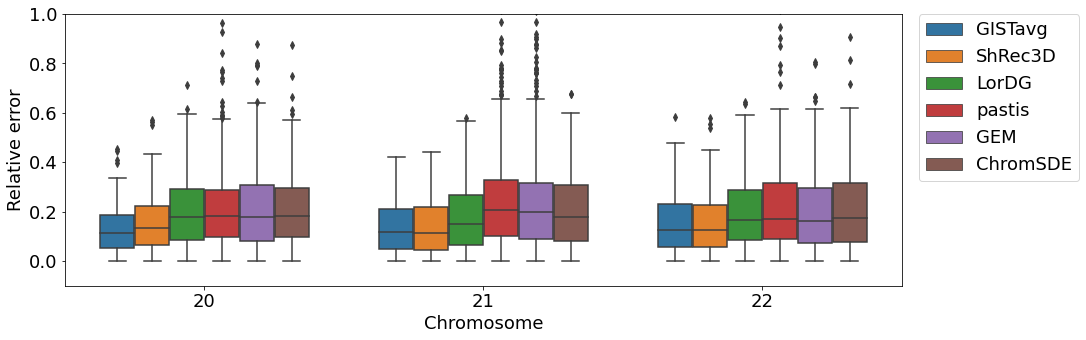

In [13]:
fig, axs = plt.subplots(1, 1,figsize=(15, 5))
diff = dict()
data = dict()
# bestkey = dict()
x, y, z = [], [], []
for chrom in chroms:
    diff[chrom] = dict()
    avg_fishTAD_3d = np.nanmean(fish3d_pdist[chrom], axis=0)
    for key, pdist in xTAD_pdist[chrom].items():
        avg_xTAD_3d = np.nanmean(pdist, axis=0)
        msku = np.zeros_like(avg_fishTAD_3d).astype(bool)
        msku[np.triu_indices_from(msku, k=0)] = True
        ff3d = avg_fishTAD_3d[msku.astype(bool)].flatten()
        fx3d = avg_xTAD_3d[msku.astype(bool)].flatten()

        params = curve_fit(fit_func, fx3d, ff3d)
        [scale, offset] = params[0]# diff = np.abs(avg_fish3d - (scale*(avg_x3d)+offset) )/avg_fish3d
        
        if 'GIST_'in key:
            continue
        else:
            diff[chrom][key] = np.abs(avg_fishTAD_3d - (scale*(avg_xTAD_3d)+offset))/avg_fishTAD_3d
            diff[chrom][key] = np.nan_to_num(diff[chrom][key], np.inf)
            mask = np.zeros_like(diff[chrom][key]).astype(bool)
            mask[np.triu_indices_from(mask, k=0)] = True
            x.append( diff[chrom][key][mask].flatten())
            y.append( np.repeat(key, len(diff[chrom][key][mask].flatten()) ))
            z.append( np.repeat(chrom, len(diff[chrom][key][mask].flatten()) ))
            
data['Relative error'] = np.concatenate(x)
data['Model'] = np.concatenate(y)
data['Chromosome'] = np.concatenate(z)
df = pd.DataFrame(data)
g = sns.boxplot(data=df, x='Chromosome', y='Relative error', hue='Model', width=.75, whis=1.5, ax=axs)
g.set(ylim=(-0.1, 1))
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()
if SAVE_FIG:
    sp = os.path.join(saved_path, 'relative_error_boxplot.pdf')
    fig.savefig(sp, format='pdf', bbox_inches='tight')

dict_keys(['GISTavg', 'ShRec3D', 'LorDG', 'pastis', 'GEM', 'ChromSDE'])
dict_keys(['GISTavg', 'ShRec3D', 'LorDG', 'pastis', 'GEM', 'ChromSDE'])
dict_keys(['GISTavg', 'ShRec3D', 'LorDG', 'pastis', 'GEM', 'ChromSDE'])


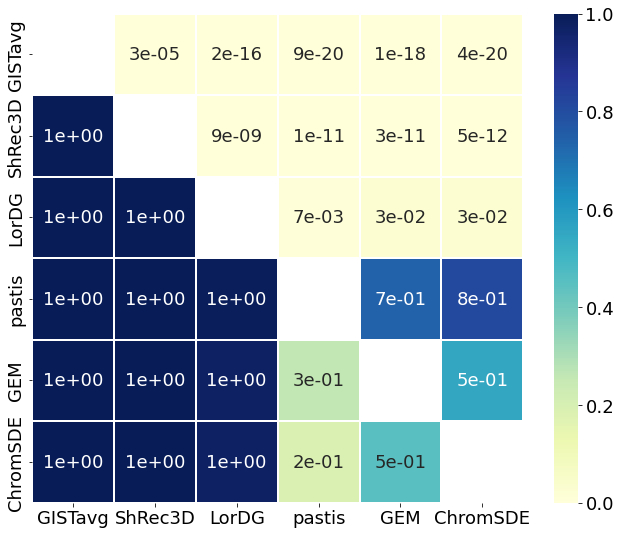

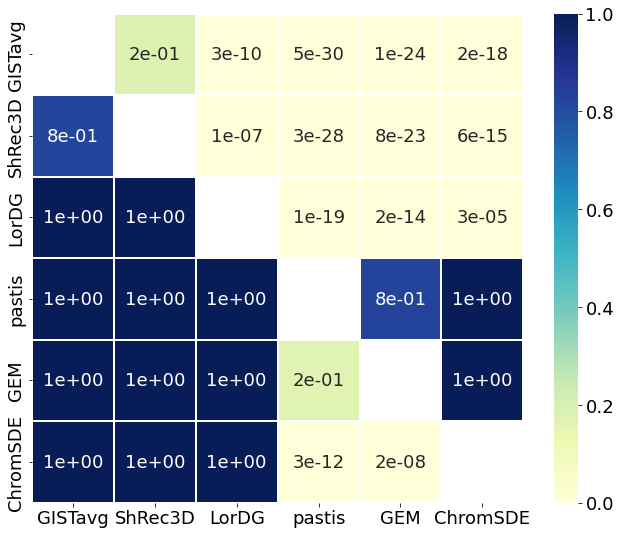

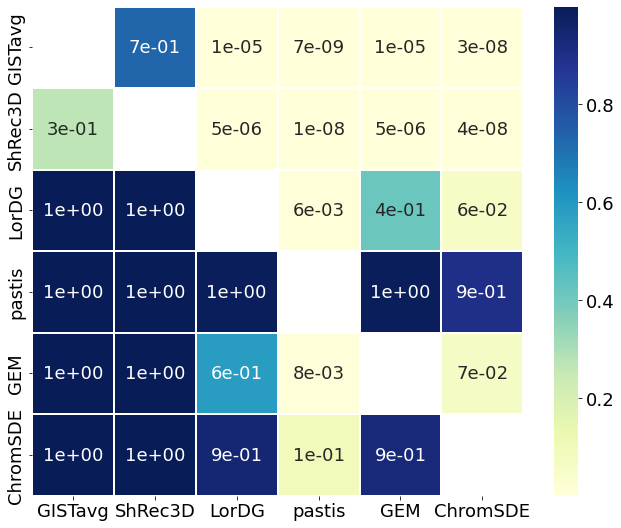

In [14]:
for chrom in chroms:
    avg_fishTAD_3d = np.nanmean(fish3d_pdist[chrom], axis=0)
    msku = np.zeros_like(avg_fishTAD_3d).astype(bool)
    msku[np.triu_indices_from(msku, k=0)] = True
    print(diff[chrom].keys())
    pvalue = np.zeros((len(diff[chrom]), len(diff[chrom])))
    pvalue.fill(np.nan)
    x = [None]*(len(diff[chrom]))
    y = [None]*(len(diff[chrom]))
    for i, (ik, iv) in enumerate(diff[chrom].items()):
        if 'GIST_' in ik:
            continue
        x[i] = ik
        for j, (jk,jv) in enumerate(diff[chrom].items()):
            if 'GIST_' in jk:
                continue
            y[j] = jk
            if ik==jk:
                continue
            rvs1 = iv[msku].reshape(-1,1)
            rvs2 = jv[msku].reshape(-1,1)
            _, p = stats.ttest_rel(rvs1, rvs2, alternative='less')
            pvalue[i, j] = p
    df =pd.DataFrame(pvalue, index=x, columns=y)
    fig, ax = plt.subplots(1,1, figsize=(11, 9))
    g = sns.heatmap(df,cmap="YlGnBu", linewidths=.1, annot=True, fmt="0.0e", ax=ax)
    if SAVE_FIG:
        sp = os.path.join(saved_path,  'chr{}'.format(chrom))
        os.makedirs(sp, exist_ok=True)
        sp = os.path.join(sp, 'relative_error_pvalue_chr{}.pdf'.format(chrom))
        fig.savefig(sp, format='pdf', bbox_inches='tight')